In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/Desktop/PhD_Stuff/cheb_bessel_tests-main`


In [2]:
using BenchmarkTools
using LinearAlgebra
using DataInterpolations
using SpecialFunctions
using HCubature
using QuadGK
using Polynomials
using Plots
using FastChebInterp
using ProgressBars
using LaTeXStrings
using Bessels
using Tullio
using FFTW
using LoopVectorization
using NPZ
using Cubature
using FastTransforms
using Interpolations
using Dierckx
using DelimitedFiles

In [3]:
using Revise
using Will

### Adapting N5K stuff

In [4]:
z_b = npzread("background/z.npy")
χ = npzread("background/chi.npy")
z_of_χ = DataInterpolations.AkimaInterpolation(z_b, χ);

In [5]:
pk_dict = npzread("../N5K/input/pk.npz")
Pklin = pk_dict["pk_lin"]
Pknonlin = pk_dict["pk_nl"]
k = pk_dict["k"]
z = pk_dict["z"];

In [6]:
y = LinRange(log10(first(k)),log10(last(k)), length(k))
x = LinRange(first(z), last(z), length(z))
InterpPmm = Interpolations.interpolate(log10.(Pklin),BSpline(Cubic(Line(OnGrid()))))
InterpPmm = scale(InterpPmm, x, y)
InterpPmm = Interpolations.extrapolate(InterpPmm, Line());

In [7]:
y = LinRange(log10(first(k)),log10(last(k)), length(k))
x = LinRange(first(z), last(z), length(z))
InterpPmm_nl = Interpolations.interpolate(log10.(Pknonlin),BSpline(Cubic(Line(OnGrid()))))
InterpPmm_nl = scale(InterpPmm_nl, x, y)
InterpPmm_nl = Interpolations.extrapolate(InterpPmm_nl, Line());

In [8]:
power_spectrum(k, χ1, χ2) = @. sqrt(10^InterpPmm(z_of_χ(χ1),log10(k)) * 10^InterpPmm(z_of_χ(χ2),log10(k)));

In [9]:
power_spectrum_nl(k, χ1, χ2) = @. sqrt(10^InterpPmm_nl(z_of_χ(χ1),log10(k)) * 10^InterpPmm_nl(z_of_χ(χ2),log10(k)));

### Loading N5K stuff

In [10]:
#N5K Cℓ's 
benchmark_gg = npzread("../N5K/tests/benchmarks_nl_full_clgg.npz")
benchmark_ll = npzread("../N5K/tests/benchmarks_nl_full_clss.npz")
benchmark_gl = npzread("../N5K/tests/benchmarks_nl_full_clgs.npz");

In [11]:
gg = benchmark_gg["cls"]
ll = benchmark_ll["cls"]
gl = benchmark_gl["cls"]
ell = benchmark_gg["ls"];

In [12]:
gg_reshaped = zeros(length(ell), 10, 10)
counter = 1

for i in 1:10
    for j in i:10
        gg_reshaped[:,i,j] = gg[counter, :]
        gg_reshaped[:,j,i] = gg_reshaped[:,i,j]
        counter += 1
    end
end

In [13]:
ll_reshaped = zeros(length(ell), 5, 5)
counter = 1

for i in 1:5
    for j in i:5
        ll_reshaped[:,i,j] = ll[counter, :]
        ll_reshaped[:,j,i] = ll_reshaped[:,i,j]
        counter += 1
    end
end

In [14]:
gl_reshaped = zeros(length(ell), 10, 5)
counter = 1

for i in 1:10
    for j in i:5
        gl_reshaped[:,i,j] = gl[counter, :]
        gl_reshaped[:,j,i] = gl_reshaped[:,i,j]
        counter += 1
    end
end

In [15]:
ell = ell[ell .<= 302]
gg_reshaped = gg_reshaped[1:length(ell),:,:]
gl_reshaped = gl_reshaped[1:length(ell),:,:]
ll_reshaped = ll_reshaped[1:length(ell),:,:];

### Functions

In [16]:
function load_Ts(folder, nχ, nR)
    ell_vector = npzread("ell_vector.npy")[1:21] 
    full_T = zeros(21, nχ, nR, 129)
    for i in 1:21
        l_string = string(round(ell_vector[i]; digits=1))
        filename = folder * "/T_tilde_l_$l_string.npy"
        full_T[i,:,:,:] = npzread(filename)
    end
    return full_T
end;

In [17]:
function SimpsonWeightArray(n)
    number_intervals = floor((n-1)/2)
    weight_array = zeros(n)
    if n == number_intervals*2+1
        for i in 1:number_intervals
            weight_array[Int((i-1)*2+1)] += 1/3
            weight_array[Int((i-1)*2+2)] += 4/3
            weight_array[Int((i-1)*2+3)] += 1/3
        end
    else
        weight_array[1] += 0.5
        weight_array[2] += 0.5
        for i in 1:number_intervals
            weight_array[Int((i-1)*2+1)+1] += 1/3
            weight_array[Int((i-1)*2+2)+1] += 4/3
            weight_array[Int((i-1)*2+3)+1] += 1/3
        end
        weight_array[length(weight_array)]   += 0.5
        weight_array[length(weight_array)-1] += 0.5
        for i in 1:number_intervals
            weight_array[Int((i-1)*2+1)] += 1/3
            weight_array[Int((i-1)*2+2)] += 4/3
            weight_array[Int((i-1)*2+3)] += 1/3
        end
        weight_array ./= 2
    end
    return weight_array
end;

In [18]:
function make_grid(χ, R)
    return vec(χ * R')
end;

In [19]:
function grid_interpolator(W, χ, grid)

    W_interp = zeros(length(W[:,1]), length(grid))
    
    for i in 1:length(W[:,1])
        interp = AkimaInterpolation(W[i,:], χ, extrapolate=true)#BSplineInterpolation(W[i,:], χ, 3, :ArcLen, :Average, extrapolate=true)
        W_interp[i,:] = interp.(grid)
    end

    return W_interp
end;

In [20]:
function grid_interpolator(W, grid, label::String)
    if label == "C"
        W_array = W["kernels_cl"]
    elseif label == "L"
        W_array = W["kernels_sh"]
    else
        error("Label must be C or L!!!!!!!")
    end

    χ = W["chi_sh"]

    return grid_interpolator(W_array, χ, grid)
end;

In [21]:
function compute_kernels(W, χ, R)

    nχ = length(χ)
    nR = length(R)
    
    W_C = reshape(grid_interpolator(W, make_grid(χ, R), "C"), 10, nχ, nR)
    
    χ2_app = zeros(5, nχ*nR)
    for i in 1:5
        χ2_app[i,:] = make_grid(χ, R) .^ 2
    end
    
    W_L = grid_interpolator(W, make_grid(χ, R), "L")
    W_L = reshape( W_L./χ2_app , 5, nχ, nR)

    

    W_C_r1 = W_C[:,:,end]
    W_L_r1 = W_L[:,:,end]

    @tullio K_CC[i,j,c,r] := W_C_r1[i,c] * W_C[j,c,r] + W_C[i,c,r]*W_C_r1[j,c]

    @tullio K_LL[i,j,c,r] := W_L_r1[i,c] * W_L[j,c,r] + W_L[i,c,r]*W_L_r1[j,c]

    @tullio K_CL[i,j,c,r] := W_C_r1[i,c] * W_L[j,c,r] + W_C[i,c,r]*W_L_r1[j,c]

    return K_CC, K_CL, K_LL
end;

In [22]:
function C_ell_computation_simpson(w, K) 
    
    nχ = length(w[1,:,1])
    nR = length(w[1,1,:])

    χ = LinRange(26,7000,nχ)
    R = LinRange(0,1, nR+1)[2:end]

    Δχ = ((last(χ)-first(χ))/(nχ-1))
    pesi_χ = SimpsonWeightArray(nχ)
    ΔR = ((last(R)-first(R))/(nR-1))
    pesi_R = SimpsonWeightArray(nR)
        
    @tullio Cℓ[l,i,j] := χ[n]*K[i,j,n,m]*w[l,n,m]*pesi_χ[n]*pesi_R[m]*Δχ*ΔR
    
    return Cℓ
    
end;

In [23]:
function C_ell_computation_simpson_uneven_grid(w, K, n_a, n_b) 
    nχ = length(w[1,:,1])
    nR = n_a + n_b +2

    χ = LinRange(26,7000,nχ)
    R1 = LinRange(0,0.9,n_a + 1)[2:end]
    R2 = LinRange(0.9,1,n_b + 1)[2:end]

    Δχ = ((last(χ)-first(χ))/(nχ-1))
    pesi_χ = SimpsonWeightArray(nχ)
    ΔR1 = ((last(R1)-first(R1))/(length(R1)-1))
    pesi_R1 = SimpsonWeightArray(length(R1))
    ΔR2 = ((last(R2)-first(R2))/(length(R2)-1))
    pesi_R2 = SimpsonWeightArray(length(R2))

    a = ones(length(R1))*ΔR1 
    b = ones(length(R2))*ΔR2 
    ΔR = vcat(a,b)
    pesi_R = vcat(pesi_R1,pesi_R2)
        
    @tullio Cℓ[l,i,j] := χ[n]*K[i,j,n,m]*w[l,n,m]*pesi_χ[n]*pesi_R[m]*Δχ*ΔR[m]
    
    return Cℓ
end;

In [24]:
function factorial_frac(n)
    return (n-1)*n*(n+1)*(n+2)
end;

Cosmic Variance
$$\sigma^{AB}_{ij}(\ell) = \sqrt{\frac{(C^{AA}_{ii}(\ell)+N_{ii}^{AA})(C^{BB}_{jj}(\ell)+N_{jj}^{BB}) + (C^{AB}_{ij}(\ell))^2}{f_{sky}(2 \ell +1)}}$$

In [25]:
function cosmic_variance(Cℓ_CC, Cℓ_LL, Cℓ_CL, f_sky=1)
    ell_vector = npzread("ell_vector.npy")[1:21]

    n̄ = 4.8 * (3437.746771)^2
    σ_ϵ = 0.3

    N_CC = 1/n̄
    N_LL = σ_ϵ^2/n̄

    @tullio σ_CC[l,i,j] := sqrt(((Cℓ_CC[l,i,i]+N_CC)^2 + Cℓ_CC[l,i,j]^2)/(f_sky*(2*ell_vector[l]+1)))
    @tullio σ_LL[l,i,j] := sqrt(((Cℓ_LL[l,i,i]+N_LL)^2 + Cℓ_LL[l,i,j]^2)/(f_sky*(2*ell_vector[l]+1)))
    @tullio σ_CL[l,i,j] := sqrt(((Cℓ_CC[l,i,i]+N_CC)*(Cℓ_LL[l,j,j]+N_LL) + Cℓ_CL[l,i,j]^2)/(f_sky*(2*ell_vector[l]+1)))

    return σ_CC, σ_LL, σ_CL
end;

$$MAER_{ij}^{AB}(\ell) = \frac{|C_{ij,Cheb}^{AB}(\ell) - C_{ij,GT}^{AB}(\ell)|}{\sigma^{AB}_{ij}(\ell)}$$

In [26]:
function MAER(Cℓ_cheb, Cℓ_n5k, σ)
    @tullio maer[l,i,j] := abs(Cℓ_cheb[l,i,j]-Cℓ_n5k[l,i,j])/σ[l,i,j]
    return maer
end;

### Loading my $w_\ell$'s

In [27]:
kmax = 200/13 
kmin = 2.5/7000
n_cheb = 128
k_cheb = chebpoints(n_cheb, log10(kmin), log10(kmax));
nχ = 100
χ = LinRange(26, 7000, nχ)
ℓ = npzread("ell_vector.npy")[1:21];

In [28]:
gg_interp = zeros(21,10,10)
ll_interp = zeros(21,5,5)
gl_interp = zeros(21,10,5)

for i in 1:10
    for j in i:10
        interpol = AkimaInterpolation(gg_reshaped[:,i,j], ell)
        gg_interp[:,i,j] = interpol.(ℓ)
        gg_interp[:,j,i] = gg_interp[:,i,j]
    end
end

for i in 1:5
    for j in i:5
        interpol = AkimaInterpolation(ll_reshaped[:,i,j], ell)
        ll_interp[:,i,j] = interpol.(ℓ)
        ll_interp[:,j,i] = ll_interp[:,i,j]
    end
end

for i in 1:10
    for j in 1:5
        interpol = AkimaInterpolation(gl_reshaped[:,i,j], ell)
        gl_interp[:,i,j] = interpol.(ℓ)
    end
end

#### 300+150

In [29]:
R_A = unique(vcat(LinRange(0,0.9,300)[2:end], LinRange(0.9,1,151)))
nR_A = length(R_A)
coeff_A = zeros(nχ,nR_A,n_cheb+1)

for i in 1:nR_A
    for j in 1:nχ
        c = chebinterp(power_spectrum.(10 .^ k_cheb,χ[j],χ[j]*R_A[i]), log10(kmin), log10(kmax)); 
        coeff_A[j,i,:] = c.coefs
    end
end

In [30]:
T_LL = load_Ts("Ts_4_real/T_tilde_LL_300+150", nχ, nR_A+1)[:,:,2:end,:]
T_CL = load_Ts("Ts_4_real/T_tilde_CL_300+150", nχ, nR_A+1)[:,:,2:end,:]
T_CC = load_Ts("Ts_4_real/T_tilde_CC_300+150", nχ, nR_A+1)[:,:,2:end,:]


w_LL_A = Will.w_ell_tullio(coeff_A, T_LL)
w_CL_A = Will.w_ell_tullio(coeff_A, T_CL)
w_CC_A = Will.w_ell_tullio(coeff_A, T_CC);

#### 100+150

In [31]:
R_B = unique(vcat(LinRange(0,0.9,101)[2:end], LinRange(0.9,1,151)))
nR_B = length(R_B)
coeff_B = zeros(nχ,nR_B,n_cheb+1)

for i in 1:nR_B
    for j in 1:nχ
        c = chebinterp(power_spectrum.(10 .^ k_cheb,χ[j],χ[j]*R_B[i]), log10(kmin), log10(kmax)); 
        coeff_B[j,i,:] = c.coefs
    end
end

In [32]:
T_LL = load_Ts("Ts_4_real/T_tilde_LL_100+150", nχ, nR_B)
T_CL = load_Ts("Ts_4_real/T_tilde_CL_100+150", nχ, nR_B)
T_CC = load_Ts("Ts_4_real/T_tilde_CC_100+150", nχ, nR_B)


w_LL_B = Will.w_ell_tullio(coeff_B, T_LL)
w_CL_B = Will.w_ell_tullio(coeff_B, T_CL)
w_CC_B = Will.w_ell_tullio(coeff_B, T_CC);

#### 75+150(finishing up on narval)

In [33]:
R_C = unique(vcat(LinRange(0,0.9,76)[2:end], LinRange(0.9,1,151)))
nR_C = length(R_C)
coeff_C = zeros(nχ,nR_C,n_cheb+1)

for i in 1:nR_C
    for j in 1:nχ
        c = chebinterp(power_spectrum.(10 .^ k_cheb,χ[j],χ[j]*R_C[i]), log10(kmin), log10(kmax)); 
        coeff_C[j,i,:] = c.coefs
    end
end

In [34]:
T_LL = load_Ts("Ts_4_real/T_tilde_LL_75+150", nχ, nR_C)
T_CL = load_Ts("Ts_4_real/T_tilde_CL_75+150", nχ, nR_C)
T_CC = load_Ts("Ts_4_real/T_tilde_CC_75+150", nχ, nR_C)


w_LL_C = Will.w_ell_tullio(coeff_C, T_LL)
w_CL_C = Will.w_ell_tullio(coeff_C, T_CL)
w_CC_C = Will.w_ell_tullio(coeff_C, T_CC);

#### 100+100(running on symmetry)

In [37]:
R_D = unique(vcat(LinRange(0,0.9,101)[2:end], LinRange(0.9,1,101)))
nR_D = length(R_D)
coeff_D = zeros(nχ,nR_D,n_cheb+1)

for i in 1:nR_D
    for j in 1:nχ
        c = chebinterp(power_spectrum.(10 .^ k_cheb,χ[j],χ[j]*R_D[i]), log10(kmin), log10(kmax)); 
        coeff_D[j,i,:] = c.coefs
    end
end

In [39]:
T_LL = load_Ts("Ts_4_real/T_tilde_LL_100+100", nχ, nR_D)
T_CL = load_Ts("Ts_4_real/T_tilde_CL_100+100", nχ, nR_D)
T_CC = load_Ts("Ts_4_real/T_tilde_CC_100+100", nχ, nR_D)


w_LL_D = Will.w_ell_tullio(coeff_D, T_LL)
w_CL_D = Will.w_ell_tullio(coeff_D, T_CL)
w_CC_D = Will.w_ell_tullio(coeff_D, T_CC);

### Limber functions!!

# $C_\ell$'s computation

In [40]:
Cℓ_CC_limb = npzread("Cl_CC_limber_linear.npy")
Cℓ_CL_limb = npzread("Cl_CL_limber_linear.npy")
Cℓ_LL_limb = npzread("Cl_LL_limber_linear.npy");

In [41]:
Cℓ_CC_limb_nl = npzread("Cl_CC_limber_nl.npy")
Cℓ_CL_limb_nl = npzread("Cl_CL_limber_nl.npy")
Cℓ_LL_limb_nl = npzread("Cl_LL_limber_nl.npy");

In [43]:
W = npzread("../N5K/input/kernels_fullwidth.npz")
@time K_CC_A, K_CL_A, K_LL_A = compute_kernels(W, χ, R_A)
@time K_CC_B, K_CL_B, K_LL_B = compute_kernels(W, χ, R_B)
@time K_CC_C, K_CL_C, K_LL_C = compute_kernels(W, χ, R_C)
@time K_CC_D, K_CL_D, K_LL_D = compute_kernels(W, χ, R_D);

  0.055517 seconds (860 allocations: 83.407 MiB)
  0.023763 seconds (789 allocations: 48.937 MiB)
  0.021075 seconds (789 allocations: 44.609 MiB)
  0.021188 seconds (903 allocations: 40.288 MiB)


#### 300+150

In [44]:
Cℓ_CC_A = C_ell_computation_simpson_uneven_grid(w_CC_A, K_CC_A, 299, 150);
Cℓ_CL_A = C_ell_computation_simpson_uneven_grid(w_CL_A, K_CL_A, 299, 150);
Cℓ_LL_A = C_ell_computation_simpson_uneven_grid(w_LL_A, K_LL_A, 299, 150);

In [45]:
# ADDING ELL PREFACTORS
Cℓ_CC_A = Cℓ_CC_A .* (2/π)

for i in 1:length(ℓ)
    Cℓ_LL_A[i,:,:] = Cℓ_LL_A[i,:,:] .* 2 .* factorial_frac(ℓ[i]) ./ π
    Cℓ_CL_A[i,:,:] = Cℓ_CL_A[i,:,:] .* 2 .* sqrt.(factorial_frac(ℓ[i])) ./ π
end

In [46]:
final_Cℓ_CC_A = Cℓ_CC_A + Cℓ_CC_limb_nl - Cℓ_CC_limb
final_Cℓ_CL_A = Cℓ_CL_A + Cℓ_CL_limb_nl - Cℓ_CL_limb
final_Cℓ_LL_A = Cℓ_LL_A + Cℓ_LL_limb_nl - Cℓ_LL_limb;

In [47]:
@time σ_CC_A, σ_LL_A, σ_CL_A = cosmic_variance(final_Cℓ_CC_A, final_Cℓ_LL_A, final_Cℓ_CL_A, 0.4);

  4.423407 seconds (14.33 M allocations: 2.029 GiB, 3.12% gc time, 99.96% compilation time)


In [48]:
@time begin 
    m_CC_A = MAER(final_Cℓ_CC_A, gg_interp, σ_CC_A)
    m_LL_A = MAER(final_Cℓ_LL_A, ll_interp, σ_LL_A)
    m_CL_A = MAER(final_Cℓ_CL_A, gl_interp, σ_CL_A)
end;

  0.478283 seconds (1.43 M allocations: 76.458 MiB, 99.99% compilation time)


#### 100+150

In [49]:
Cℓ_CC_B = C_ell_computation_simpson_uneven_grid(w_CC_B, K_CC_B, 100, 150);
Cℓ_CL_B = C_ell_computation_simpson_uneven_grid(w_CL_B, K_CL_B, 100, 150);
Cℓ_LL_B = C_ell_computation_simpson_uneven_grid(w_LL_B, K_LL_B, 100, 150);

In [50]:
# ADDING ELL PREFACTORS
Cℓ_CC_B = Cℓ_CC_B .* (2/π)

for i in 1:length(ℓ)
    Cℓ_LL_B[i,:,:] = Cℓ_LL_B[i,:,:] .* 2 .* factorial_frac(ℓ[i]) ./ π
    Cℓ_CL_B[i,:,:] = Cℓ_CL_B[i,:,:] .* 2 .* sqrt.(factorial_frac(ℓ[i])) ./ π
end

In [51]:
final_Cℓ_CC_B = Cℓ_CC_B + Cℓ_CC_limb_nl - Cℓ_CC_limb
final_Cℓ_CL_B = Cℓ_CL_B + Cℓ_CL_limb_nl - Cℓ_CL_limb
final_Cℓ_LL_B = Cℓ_LL_B + Cℓ_LL_limb_nl - Cℓ_LL_limb;

In [52]:
@time σ_CC_B, σ_LL_B, σ_CL_B = cosmic_variance(final_Cℓ_CC_B, final_Cℓ_LL_B, final_Cℓ_CL_B,0.4);

  0.004759 seconds (59 allocations: 33.547 KiB)


In [53]:
@time begin 
    m_CC_B = MAER(final_Cℓ_CC_B, gg_interp, σ_CC_B)
    m_LL_B = MAER(final_Cℓ_LL_B, ll_interp, σ_LL_B)
    m_CL_B = MAER(final_Cℓ_CL_B, gl_interp, σ_CL_B)
end;

  0.000046 seconds (4 allocations: 29.125 KiB)


#### 75+150

In [54]:
Cℓ_CC_C = C_ell_computation_simpson_uneven_grid(w_CC_C, K_CC_C, 75, 150);
Cℓ_CL_C = C_ell_computation_simpson_uneven_grid(w_CL_C, K_CL_C, 75, 150);
Cℓ_LL_C = C_ell_computation_simpson_uneven_grid(w_LL_C, K_LL_C, 75, 150);

In [55]:
# ADDING ELL PREFACTORS
Cℓ_CC_C = Cℓ_CC_C .* (2/π)

for i in 1:length(ℓ)
    Cℓ_LL_C[i,:,:] = Cℓ_LL_C[i,:,:] .* 2 .* factorial_frac(ℓ[i]) ./ π
    Cℓ_CL_C[i,:,:] = Cℓ_CL_C[i,:,:] .* 2 .* sqrt.(factorial_frac(ℓ[i])) ./ π
end

In [56]:
final_Cℓ_CC_C = Cℓ_CC_C + Cℓ_CC_limb_nl - Cℓ_CC_limb
final_Cℓ_CL_C = Cℓ_CL_C + Cℓ_CL_limb_nl - Cℓ_CL_limb
final_Cℓ_LL_C = Cℓ_LL_C + Cℓ_LL_limb_nl - Cℓ_LL_limb;

In [57]:
@time σ_CC_C, σ_LL_C, σ_CL_C = cosmic_variance(final_Cℓ_CC_C, final_Cℓ_LL_C, final_Cℓ_CL_C, 0.4);

  0.002605 seconds (59 allocations: 33.547 KiB)


In [58]:
@time begin 
    m_CC_C = MAER(final_Cℓ_CC_C, gg_interp, σ_CC_C)
    m_LL_C = MAER(final_Cℓ_LL_C, ll_interp, σ_LL_C)
    m_CL_C = MAER(final_Cℓ_CL_C, gl_interp, σ_CL_C)
end;

  0.000059 seconds (4 allocations: 29.125 KiB)


#### 100+100

In [59]:
Cℓ_CC_D = C_ell_computation_simpson_uneven_grid(w_CC_D, K_CC_D, 100, 100);
Cℓ_CL_D = C_ell_computation_simpson_uneven_grid(w_CL_D, K_CL_D, 100, 100);
Cℓ_LL_D = C_ell_computation_simpson_uneven_grid(w_LL_D, K_LL_D, 100, 100);

In [60]:
# ADDING ELL PREFACTORS
Cℓ_CC_D = Cℓ_CC_D .* (2/π)

for i in 1:length(ℓ)
    Cℓ_LL_D[i,:,:] = Cℓ_LL_D[i,:,:] .* 2 .* factorial_frac(ℓ[i]) ./ π
    Cℓ_CL_D[i,:,:] = Cℓ_CL_D[i,:,:] .* 2 .* sqrt.(factorial_frac(ℓ[i])) ./ π
end

In [61]:
final_Cℓ_CC_D = Cℓ_CC_D + Cℓ_CC_limb_nl - Cℓ_CC_limb
final_Cℓ_CL_D = Cℓ_CL_D + Cℓ_CL_limb_nl - Cℓ_CL_limb
final_Cℓ_LL_D = Cℓ_LL_D + Cℓ_LL_limb_nl - Cℓ_LL_limb;

In [62]:
@time σ_CC_D, σ_LL_D, σ_CL_D = cosmic_variance(final_Cℓ_CC_D, final_Cℓ_LL_D, final_Cℓ_CL_D,0.4);

  0.001047 seconds (59 allocations: 33.547 KiB)


In [63]:
@time begin 
    m_CC_D = MAER(final_Cℓ_CC_D, gg_interp, σ_CC_D)
    m_LL_D = MAER(final_Cℓ_LL_D, ll_interp, σ_LL_D)
    m_CL_D = MAER(final_Cℓ_CL_D, gl_interp, σ_CL_D)
end;

  0.000021 seconds (4 allocations: 29.125 KiB)


# Plots 

## CC

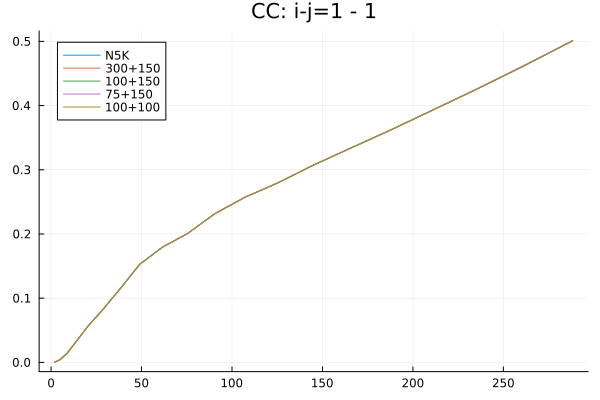

In [66]:
i = 1
j = 1
plot(ℓ, gg_interp[:,i,j] .* ℓ .* (ℓ .+ 1), title = "CC: i-j=$i - $j", label="N5K")#, xlim=(2,302)), xscale=:log10)
plot!(ℓ, final_Cℓ_CC_A[:,i,j] .* ℓ .* (ℓ .+ 1) , label = "300+150")
plot!(ℓ, final_Cℓ_CC_B[:,i,j] .* ℓ .* (ℓ .+ 1) , label = "100+150")
plot!(ℓ, final_Cℓ_CC_C[:,i,j] .* ℓ .* (ℓ .+ 1) , label = "75+150")
plot!(ℓ, final_Cℓ_CC_D[:,i,j] .* ℓ .* (ℓ .+ 1) , label = "100+100")

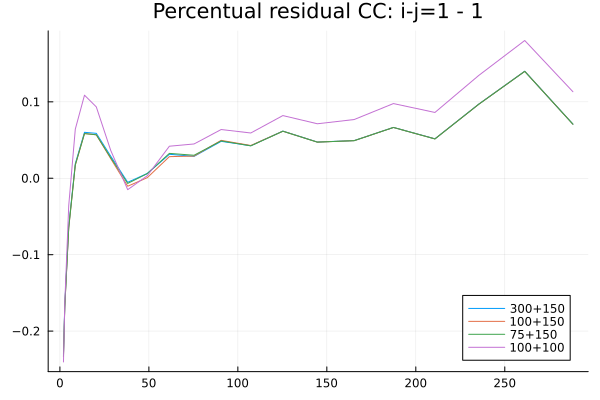

In [67]:
plot(ℓ, 100*(1 .- final_Cℓ_CC_A[:,i,j]./gg_interp[:,i,j]), label="300+150", title = "Percentual residual CC: i-j=$i - $j")
plot!(ℓ, 100*(1 .- final_Cℓ_CC_B[:,i,j]./gg_interp[:,i,j]), label="100+150")
plot!(ℓ, 100*(1 .- final_Cℓ_CC_C[:,i,j]./gg_interp[:,i,j]), label="75+150")
plot!(ℓ, 100*(1 .- final_Cℓ_CC_D[:,i,j]./gg_interp[:,i,j]), label="100+100")
#plot!(ℓ, 100*(1 .- final_Cℓ_CC_B[:,i,j]./final_Cℓ_CC_A[:,i,j]), label="A-B")

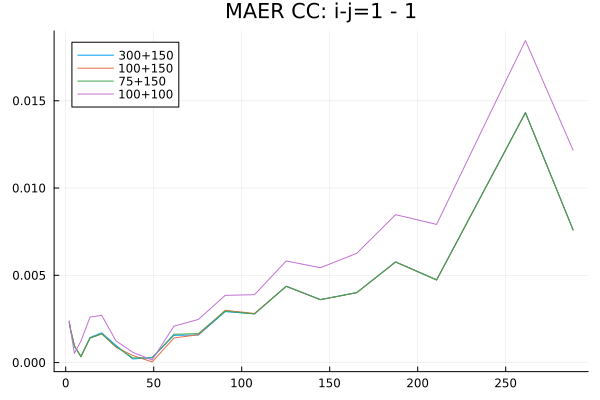

In [68]:
plot(ℓ, m_CC_A[:,i,j], label="300+150", title = "MAER CC: i-j=$i - $j")
plot!(ℓ, m_CC_B[:,i,j], label="100+150")
plot!(ℓ, m_CC_C[:,i,j], label="75+150")
plot!(ℓ, m_CC_D[:,i,j], label="100+100")

## LL

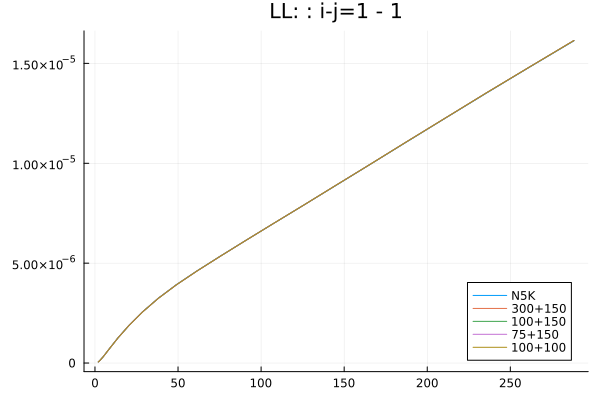

In [76]:
i = 1
j = 1
plot(ℓ, ll_interp[:,i,j] .* ℓ .* (ℓ .+ 1), title = "LL: : i-j=$i - $j", label="N5K")#, xlim=(2,302),ylim=(0,0.0001))
plot!(ℓ, final_Cℓ_LL_A[:,i,j] .* ℓ .* (ℓ .+ 1) , label = "300+150")
plot!(ℓ, final_Cℓ_LL_B[:,i,j] .* ℓ .* (ℓ .+ 1) , label = "100+150")
plot!(ℓ, final_Cℓ_LL_C[:,i,j] .* ℓ .* (ℓ .+ 1) , label = "75+150")
plot!(ℓ, final_Cℓ_LL_D[:,i,j] .* ℓ .* (ℓ .+ 1) , label = "100+100",legend=:bottomright)

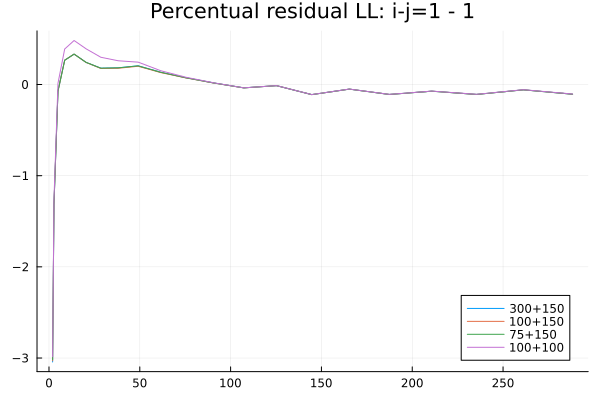

In [77]:
plot(ℓ, 100*(1 .- final_Cℓ_LL_A[:,i,j]./ll_interp[:,i,j]), label="300+150",title = "Percentual residual LL: i-j=$i - $j")
plot!(ℓ, 100*(1 .- final_Cℓ_LL_B[:,i,j]./ll_interp[:,i,j]), label="100+150")
plot!(ℓ, 100*(1 .- final_Cℓ_LL_C[:,i,j]./ll_interp[:,i,j]), label="75+150")
plot!(ℓ, 100*(1 .- final_Cℓ_LL_D[:,i,j]./ll_interp[:,i,j]), label="100+100")
#plot!(ℓ, 100*(1 .- final_Cℓ_LL_B[:,i,j]./final_Cℓ_LL_A[:,i,j]), label="A-B")

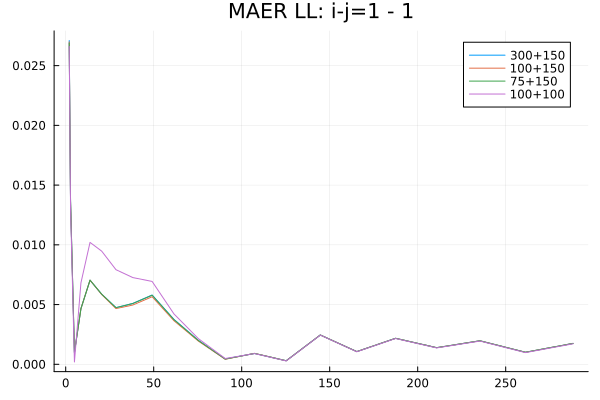

In [78]:
plot(ℓ, m_LL_A[:,i,j], label="300+150", title = "MAER LL: i-j=$i - $j")
plot!(ℓ, m_LL_B[:,i,j], label="100+150")
plot!(ℓ, m_LL_C[:,i,j], label="75+150")
plot!(ℓ, m_LL_D[:,i,j], label="100+100")

## CL

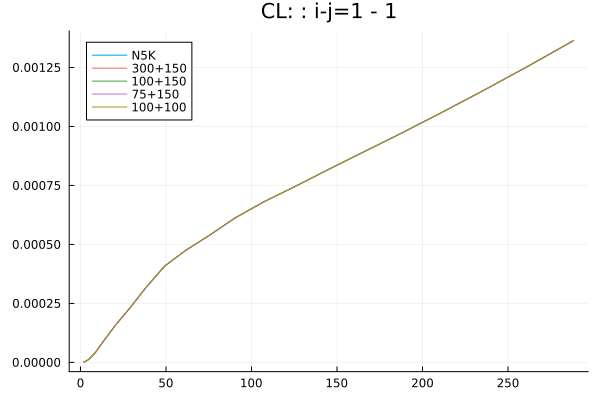

In [72]:
i = 1
j = 1
plot(ℓ, gl_interp[:,i,j] .* ℓ .* (ℓ .+ 1), title = "CL: : i-j=$i - $j", label="N5K")#, xlim=(2,302),ylim=(0,0.002))#, yscale=:log10)
plot!(ℓ, final_Cℓ_CL_A[:,i,j] .* ℓ .* (ℓ .+ 1) , label = "300+150")
plot!(ℓ, final_Cℓ_CL_B[:,i,j] .* ℓ .* (ℓ .+ 1) , label = "100+150")
plot!(ℓ, final_Cℓ_CL_C[:,i,j] .* ℓ .* (ℓ .+ 1) , label = "75+150")
plot!(ℓ, final_Cℓ_CL_D[:,i,j] .* ℓ .* (ℓ .+ 1) , label = "100+100")

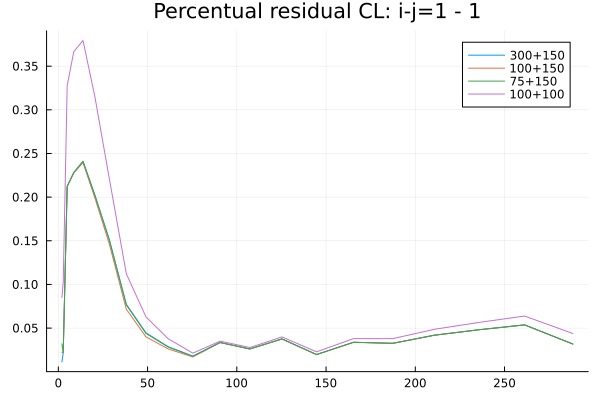

In [74]:
plot(ℓ, 100*(1 .- final_Cℓ_CL_A[:,i,j]./gl_interp[:,i,j]), label="300+150",title = "Percentual residual CL: i-j=$i - $j")
plot!(ℓ, 100*(1 .- final_Cℓ_CL_B[:,i,j]./gl_interp[:,i,j]), label="100+150")
plot!(ℓ, 100*(1 .- final_Cℓ_CL_C[:,i,j]./gl_interp[:,i,j]), label="75+150")
plot!(ℓ, 100*(1 .- final_Cℓ_CL_D[:,i,j]./gl_interp[:,i,j]), label="100+100")
#plot!(ℓ, 100*(1 .- final_Cℓ_CL_B[:,i,j]./final_Cℓ_CL_A[:,i,j]), label="A-B")

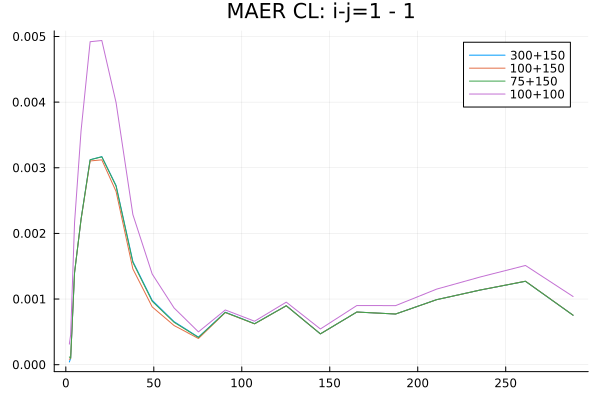

In [75]:
plot(ℓ, m_CL_A[:,i,j], label="300+150", title = "MAER CL: i-j=$i - $j")
plot!(ℓ, m_CL_B[:,i,j], label="100+150")
plot!(ℓ, m_CL_C[:,i,j], label="75+150")
plot!(ℓ, m_CL_D[:,i,j], label="100+100")